# CSS utility

Functions that can be exploited for data pre-processing and downstream analysis

In [1]:
# ### To convert the file into .py
# !jupyter nbconvert --to script css_utility_working.ipynb

In [2]:
import os
import re
import random
import operator
import itertools
import pickle
import glob
import ast
import collections
from collections import defaultdict, OrderedDict, Counter
import datetime
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
import matplotlib.transforms as transforms
import networkx as nx

import seaborn as sns
from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering
from tslearn.metrics import dtw

from tqdm import tqdm, notebook
from tqdm.notebook import tqdm_notebook

from wordcloud import WordCloud
# import stylecloud

### Useful Dictionaries

In [3]:
state_dict={1:"A", 2:"B", 3:"C", 4:"D", 5:"E",6:"F",7:"G",8:"H" ,
                9:"I" ,10:"J",11:"K", 12:"L", 13:"M", 14:"N", 15:"O"}

In [4]:
css_name=['TssA','TssAFlnk','TxFlnk','Tx','TxWk','EnhG','Enh','ZNF/Rpts',
          'Het','TssBiv','BivFlnk','EnhBiv','ReprPC','ReprPcWk','Quies']

In [5]:
css_dict=dict(zip(list(state_dict.values()), css_name))  # css_dict={"A":"TssA", "B":"TssAFlnk", ... }

In [6]:
# Color dict update using the info from https://egg2.wustl.edu/roadmap/web_portal/chr_state_learning.html
css_color_dict={'TssA':(255,0,0), # Red
                'TssAFlnk': (255,69,0), # OrangeRed
                'TxFlnk': (50,205,50), # LimeGreen
                'Tx': (0,128,0), # Green
                'TxWk': (0,100,0), # DarkGreen
                'EnhG': (194,225,5), # GreenYellow 
                'Enh': (255,255,0),# Yellow
                'ZNF/Rpts': (102,205,170), # Medium Aquamarine
                'Het': (138,145,208), # PaleTurquoise
                'TssBiv': (205,92,92), # IndianRed
                'BivFlnk': (233,150,122), # DarkSalmon
                'EnhBiv': (189,183,107), # DarkKhaki
                'ReprPC': (128,128,128), # Silver
                'ReprPCWk': (192,192,192), # Gainsboro
                'Quies': (240, 240, 240)}  # White -> bright gray 

In [7]:
state_col_dict_num={'A': (1.0, 0.0, 0.0),
 'B': (1.0, 0.271, 0.0),
 'C': (0.196, 0.804, 0.196),
 'D': (0.0, 0.502, 0.0),
 'E': (0.0, 0.392, 0.0),
 'F': (0.761, 0.882, 0.02),
 'G': (1.0, 1.0, 0.0),
 'H': (0.4, 0.804, 0.667),
 'I': (0.541, 0.569, 0.816),
 'J': (0.804, 0.361, 0.361),
 'K': (0.914, 0.588, 0.478),
 'L': (0.741, 0.718, 0.42),
 'M': (0.502, 0.502, 0.502),
 'N': (0.753, 0.753, 0.753),
 'O': (0.941, 0.941, 0.941)}

In [8]:
def colors2color_dec(css_color_dict):
    colors=list(css_color_dict.values())
    color_dec_list=[]
    for color in colors:
        color_dec=tuple(rgb_elm/255 for rgb_elm in color)
        color_dec_list.append(color_dec)        
    return color_dec_list

**scale 0 to 1**

In [9]:
state_col_dict=dict(zip(list(state_dict.values()),colors2color_dec(css_color_dict)))

**scale 0 to 255**

In [10]:
state_col_255_dict=dict(zip(list(state_dict.values()),list(css_color_dict.values())))

**hexacode**

In [11]:
hexa_state_col_dict={letter: "#{:02x}{:02x}{:02x}".format(*rgb) for letter,rgb in state_col_255_dict.items()}

**name instead of alphabets**

In [12]:
css_name_col_dict=dict(zip(css_name,state_col_dict.values()))

### Helper functions

In [13]:
def flatLst(lst):
    flatten_lst=[elm for sublst in lst for elm in sublst]
    return flatten_lst

In [14]:
### Produce colorful letter-represented chromatin state sequences
def colored_css_str_as_is(sub_str):   # convert space into space
    col_str=""
    for letter in sub_str:
        if letter==" ":
            col_str+=" "
        else:                
            for state in list(state_col_255_dict.keys()):
                if letter==state:
                    r=state_col_255_dict[letter][0]
                    g=state_col_255_dict[letter][1]
                    b=state_col_255_dict[letter][2]
                    col_letter="\033[38;2;{};{};{}m{}\033[38;2;255;255;255m".format(r,g,b,letter)
                    col_str+=col_letter
    return print("\033[1m"+col_str+"\033[0;0m") 

In [15]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

In [16]:
def kmer2seq(kmers):
    """
    Convert kmers to original sequence
    """
    kmers_list = kmers.split(" ")
    bases = [kmer[0] for kmer in kmers_list[0:-1]]
    bases.append(kmers_list[-1])
    seq = "".join(bases)
    assert len(seq) == len(kmers_list) + len(kmers_list[0]) - 1
    return seq


In [17]:
# create dataframe from bed file
# bed file here means: EXXX_15_coreMarks_stateno.bed

def bed2df_as_is(filename):    
    
    """Create dataframe from the .bed file, as is.
    Dataframe contains following columns:
    chromosome |  start |  end  | state """
    
    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    
    return df

### Main functions

In [18]:
def bed2df_expanded(filename):
    
    """Create an expanded dataframe from the .bed file.
    Dataframe contains following columns:
    chromosome |  start |  end  | state | length | unit | state_seq | state_seq_full"""
    if not os.path.exists(filename):
        raise FileNotFoundError("Please provide a valid file path.")

    df_raw=pd.read_csv(filename, sep='\t', lineterminator='\n', header=None, low_memory=False)
    df=df_raw.rename(columns={0:"chromosome",1:"start",2:"end",3:"state"})
    df=df[:-1]
    df["start"]=pd.to_numeric(df["start"])
    df["end"]=pd.to_numeric(df["end"])
    df["state"]=pd.to_numeric(df["state"])
    df["length"]=df["end"]-df["start"]
    df["unit"]=(df["length"]/200).astype(int)  # chromatin state is annotated every 200 bp (18th May 2022)
               
    df["state_seq"]=df["state"].map(state_dict)
    df["state_seq_full"]=df["unit"]*df["state_seq"]
    
    return df 

In [19]:
# # test for bed2df_expanded
# test_path_bed='../database/bed/unzipped/E001_15_coreMarks_stateno.bed'
# test_bed2df_expanded=bed2df_expanded(test_path_bed)
# test_bed2df_expanded.head()
# # test passed

In [20]:
def unzipped_to_df(path_unzipped, output_path="./"):
    """
    Store the DataFrame converted from .bed file, cell-wise
    - path_unzipped: the directory of your .bed files
    - output_path: the directory where the file will be saved. Dafaults to the current working directory.
    """
    unzipped_epi=sorted(os.listdir(path_unzipped))
    unzipped_epi_files=[os.path.join(path_unzipped,file) for file in unzipped_epi]
    for file in unzipped_epi_files:
        cell_id=file.split("/")[-1][:4]
        # print(cell_id) ###### for test
        
        output_name=os.path.join(output_path,cell_id+"_df_pickled.pkl")
        df=bed2df_expanded(file)
        df.to_pickle(output_name)
        # if cell_id=="E002":  ###### for test
        #     break
    return print("Files saved to {}".format(output_path))
# unzipped_to_df(unzipped_epi_files, output_path="../database/roadmap/df_pickled/")

In [21]:
# # test for unzipped_to_df
# path_unzipped='../database/bed/unzipped'
# test_unzipped_to_df=unzipped_to_df(path_unzipped,output_path="../database/final_test")
# # test passed

In [22]:
# first, learn where one chromosome ends in the df
# this is just a prerequisite function for df2css_chr

def df2chr_index(df):
    
    """Create a list of smaller piece of string of the state_seq_full per chromosome
    This function generates a list of chromatin state sequence strings chromosome-wise"""
    
    total_row=len(df)
    chr_len=[]
    chr_check=[]
    chr_index=[]

    for i in range(total_row):
        if (df["start"].iloc[i]==0) & (i >0):
            chr_len.append(df["end"].iloc[i-1]) # chr_len stores the end position of each chromosome
            chr_check.append(df["start"].iloc[i]) # for assertion : later check chr_check are all zero
            chr_index.append(i-1) # the index (row number)

    end_len=df["end"].iloc[-1] # add the final end position
    end_index=total_row-1 # add the final end index (row number)
 
    chr_len.append(end_len)
    chr_index.append(end_index)

    assert len(chr_len)==df["chromosome"].nunique() #assert the length of the list corresponds to no. of chromosome
    assert len(chr_index)==df["chromosome"].nunique()
    
    return chr_index

In [23]:
def df2chr_df(df):
   
    """Create a list of dataframes, each of which containing 
    the the whole expanded type of dataframe per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list   # elm is the df of each chromosome

In [24]:
# make a long string of the css (unit length, not the real length)
def df2unitcss(df):
    """
    Create a list of 24 lists of chromatin states in string, reduced per 200 bps
    """
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
#         assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
#     else:   
#         assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    all_unit_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["unit"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_unit_css.append(css_chr)  
    return all_unit_css

In [25]:
# # test for df2unitcss
# with open("../database/final_test/E001_df_pickled.pkl","rb") as f:
#     test_df=pickle.load(f)
# all_unit_css=df2unitcss(test_df)
# print(len(all_unit_css))
# print(type(all_unit_css))
# # test passed

In [26]:
def shorten_string(s, factor):
    # This regular expression matches groups of the same character.
    pattern = re.compile(r'(.)\1*')

    # This function will be used to replace each match.
    def replacer(match):
        # The group that was matched.
        group = match.group()

        # Calculate the new length, rounding as necessary.
        new_length = round(len(group) / factor)

        # Return the character repeated the new number of times.
        return group[0] * new_length

    # Use re.sub to replace each match in the string.
    return pattern.sub(replacer, s)

In [27]:
def Convert2unitCSS_main_new(css_lst_all, unit=200):# should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    reduced_all=[]
    for i in range(len(css_lst_all)):
        reduced_chr=[]
        for j in range(len(css_lst_all[i])):
            reduced=shorten_string(css_lst_all[i][j], unit)
            reduced_chr.append(reduced)
        reduced_all.append(reduced_chr)
    return reduced_all

In [28]:
# make a long string of the css (not using unit, but the real length)
def df2longcss(df):
    """
    Create a list of 24 lists of chromatin states in string, in real length
    """
    df_lst_chr=df2chr_df(df)
    # remove the microchondria DNA from df_lst_chr
    if df_lst_chr[-3]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-3]
#         assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    elif df_lst_chr[-2]["chromosome"].iloc[0]=="chrM":
        del df_lst_chr[-2]
#         assert df_lst_chr[-3]["chromosome"].iloc[0]=="chr22"
    
    all_css=[]
    for i in range(len(df_lst_chr)):
        df_chr=df_lst_chr[i]
        css_chr=''
        for j in range(len(df_chr)):
            css_chr+=df_chr["length"].iloc[j]*df_chr["state_seq"].iloc[j]
        all_css.append(css_chr)  
    return all_css

In [29]:
# function for preprocess the whole gene data and produce chromosome-wise gene lists
# each element is dataframe

# def whGene2GLChr(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
def whGene2GLChr(whole_gene_file):
    """
    For pre-processing the whole gene data and produce chromosome-wise gene lists
    """
    print("Extracting the gene file ...")
    g_fn=whole_gene_file
    g_df_raw=pd.read_csv(g_fn, sep='\t', lineterminator='\n', header=None, low_memory=False)
    g_df_int=g_df_raw.rename(columns={0:"chromosome",1:"TxStart",2:"TxEnd",3:"name",4:"unk0",
                                  5:'strand', 6:'cdsStart', 7:'cdsEnd',8:"unk1",9:"exonCount",
                                  10:"unk2",11:"unk3"})
    g_df=g_df_int[["chromosome","TxStart","TxEnd","name"]]
    
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chromosome"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num
        locals()[g_chr_df]=g_df[g_df["chromosome"]==chr_num]
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
    print("Done!")
    
    return g_df_chr_lst

In [30]:
#### Merging the gene table #### modified June. 29. 2023

def merge_intervals(df_list):
    merged_list = []  # List to hold merged DataFrames

    for df in df_list:
        # Sort by 'TxStart'
        df = df.sort_values(by='TxStart')

        # Initialize an empty list to store the merged intervals
        merged = []

        # Iterate through the rows in the DataFrame
        for _, row in df.iterrows():
            # If the list of merged intervals is empty, or the current interval does not overlap with the previous one,
            # append it to the list
            if not merged or merged[-1]['TxEnd'] < row['TxStart']:
                merged.append({'TxStart': row['TxStart'], 'TxEnd': row['TxEnd']})  # Only keep 'TxStart' and 'TxEnd'
            else:
                # Otherwise, there is an overlap, so we merge the current and previous intervals
                merged[-1]['TxEnd'] = max(merged[-1]['TxEnd'], row['TxEnd'])

        # Convert the merged intervals back into a DataFrame and append it to the list
        merged_list.append(pd.DataFrame(merged))

    return merged_list  # a list of DF, containing only TxStart and TxEnd

In [31]:
def remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df):
    
    ########### Gene without overlap ###########
    g_df_chr_lst=whGene2GLChr(whole_gene_file)  ##### fixed June 29. 2023
    new_gene_lst_all=merge_intervals(g_df_chr_lst) ##### fixed June 29. 2023
    ############################################################

    #### Remove chrM ###########################################
    contains_chrM = df['chromosome'].str.contains('chrM').any()  #check whether it contains M
    if contains_chrM:
        df= df[~df['chromosome'].str.contains('chrM')]

    contains_chrY = df['chromosome'].str.contains('chrY').any()

    ##### if the target file does not contain Y, remove Y in the gene list file
    if not contains_chrY:
        new_gene_lst_all=new_gene_lst_all[:-1] ## the final element is for Y
    ############################################################

    assert len(df["chromosome"].unique())==len(new_gene_lst_all)
    return new_gene_lst_all, df

In [32]:
def save_TSS_by_loc(whole_gene_file, input_path="./",output_path="./",file_name="upNkdownNk", up_num=2000, down_num=4000, unit=200):
    """
    extract TSS region by location estimation. 
    input: (1) whole_gene_file: the raw gene bed file (e.g. RefSeq.WholeGene.bed)
           (2) input_path: pickled df per cell
    output: save tss_by_loc_css_unit_all at the output path
    """
    file_lst=os.listdir(input_path)
    all_files=[os.path.join(input_path,file) for file in file_lst]
    for file in all_files:
        cell_num=file.split("/")[-1][:4]
#         if cell_num=="E002": break  # for test 
        with open(file,"rb") as f:
            df_pickled=pickle.load(f)
        # align the gene file and the df file according to their availability(some cells does not have chr Y)
        new_gene_lst_all, trimmed_df=remove_chrM_and_trim_gene_file_accordingly(whole_gene_file,df_pickled)
        css_lst_chr = df2longcss(trimmed_df) # list of long css per chromosome
        total_chr = len(new_gene_lst_all)       
        tss_by_loc_css_all = []
        for i in range(total_chr):
            gene_start_lst = new_gene_lst_all[i]["TxStart"]
            css_lst = css_lst_chr[i]
            tss_by_loc_css_chr = []
            for j in range(len(gene_start_lst)):
                gene_start = gene_start_lst[j]
                win_start = max(0, gene_start - up_num)  # use max to prevent negative index
                win_end = min(len(css_lst), gene_start + down_num)  # use min to prevent index out of range
                tss_by_loc_css = css_lst[win_start:win_end]
                tss_by_loc_css_chr.append(tss_by_loc_css)               
            tss_by_loc_css_all.append(tss_by_loc_css_chr)
        tss_by_loc_css_unit_all=Convert2unitCSS_main_new(tss_by_loc_css_all, unit=unit)  
        output_file_name=os.path.join(output_path,cell_num+"_prom_"+file_name+".pkl")
        with open(output_file_name,"wb") as g:
            pickle.dump(tss_by_loc_css_unit_all,g)

    return print("All done!") #tss_by_loc_css_unit_all

In [33]:
# # test for save_TSS_by_loc
# whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'
# save_TSS_by_loc(whole_gene_file=whole_gene_file, input_path="../database/roadmap/df_pickled/",output_path="../database/final_test/",file_name="up2kdown4k", up_num=2000, down_num=4000, unit=200)
# # test passed

In [34]:
# Pretrain data preprocessing and storing

# Preprocessing for removing continuous O state for pretrain dataset
# 1. Sace the CSS per cell, per chromosome
def save_css_by_cell_wo_continuous_15state(path_to_css_unit_pickled, output_path,k=4):
    # read files from css_unit_pickled
    files=os.listdir(path_to_css_unit_pickled)
    file_path_lst=[os.path.join(path_to_css_unit_pickled,file) for file in files]
    for file_path in file_path_lst:
        file_name=os.path.basename(file_path)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # ##########################
        with open(file_path,"rb") as f:
            css=pickle.load(f)
        css_kmer=[]
        for css_chr in css:
            css_chr_kmer=seq2kmer(css_chr,k)
            target_to_remove="O"*k   # get rid of the word with continuous 15th state "o"
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            css_kmer.append(css_chr_kmer_trim)
        output_file_name=os.path.join(output_path,file_id+"_unitcss_wo_all"+str(k)+"O_state.pkl")    
        with open(output_file_name, "wb") as g:
            pickle.dump(css_kmer, g)  # note that it is chromosome-wise list (each element corresponds to each chromosome)

        print("trimmed css by cell saved: ",file_id)
    return 

In [35]:
# Preprocessing for removing continuous O state for pretrain dataset
# 2. Concatenate all the cells and create one .txt file
# (Note. new line joining chromosome-wise and cell-wise)
def kmerCSS_to_pretrain_data(path_to_kmer_css_unit_pickled,output_path):
    files=os.listdir(path_to_kmer_css_unit_pickled)
    file_path_lst=[os.path.join(path_to_kmer_css_unit_pickled,file) for file in files]

    css_all=[]
    for file_path in file_path_lst:
        file_name=os.path.basename(file_path)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # # ##########################
        with open(file_path,"rb") as f:
            css=pickle.load(f)

        css_per_cell='\n'.join(css)   # join the chromosome by new line

        css_all.append(css_per_cell)   

    css_all_cell='\n'.join(css_all)  # join the cell by new line

    output_name=os.path.join(output_path,"pretrain_genome_all.txt") 
    with open(output_name, "w") as g:
        g.write(css_all_cell)

    return 

In [36]:

def prom_css_Kmer_by_cell(path="./", output_path="./",k=4):
    output_dir=str(k)+"mer/"
    output_path_fin=os.path.join(output_path, output_dir)
    os.makedirs(output_path_fin, exist_ok=True)

    all_files=sorted([os.path.join(path, file) for file in os.listdir(path)]) 
    
    for file in all_files:
        prom_kmer_all=[]
        cell_id=file.split("/")[-1][:4]

        # if cell_id=="E003": break # for test use
        
        with open(file, "rb") as f:
            prom=pickle.load(f)
        prom_css=flatLst(prom)  # make a list from list of a list
        prom_kmer=[seq2kmer(item,k) for item in prom_css]
        prom_kmer_all.append(prom_kmer)
        prom_kmer_all_flt=flatLst(prom_kmer_all)
        prom_kmer_all_flt_not_zero=[item for item in prom_kmer_all_flt if item!=""]
        output_name=cell_id+"_all_genes_prom_"+str(k)+"merized.txt"
        with open(output_path_fin+output_name, "w") as g:
            g.write("\n".join(prom_kmer_all_flt_not_zero))
    return 

In [37]:
# test for prom_css_Kmer_by_cell
# path="../database/roadmap/prom/up2kdown4k/all_genes/"
# output_path="../database/final_test/"
# prom_css_Kmer_by_cell(path=path, output_path=output_path, k=4)
# test passed

#### Pipeline 

(1) `prom_expGene2css` : cut the prom regions of long css <br>
(2) `extProm_wrt_g_exp` : transform css into unit length css <br>
(3) `extNsaveProm_g_exp` : load the required file and process all, and save

#### Function: `Gexp_Gene2GLChr`

* This function only checks a single file.
* Usage: After the gene expression files such as `gene_highlyexpressed.refFlat` are acquired by `/database/bed/gene_expression/classifygenes_ROADMAP_RPKM.py`, apply this function to obtain the list of dataframe per chromosome contains the transcription start and end indices.
* Input: gene expression (high/low/not) file
* Output: a chromosome-wise list of dataframe containing `TxStart` and `TxEnd`

In [38]:
# function for preprocess the whole gene data and produce chromosome-wise gene lists
# each element is dataframe

### this function is not essential, but just to check by create df from .refFlat
def Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/E050/gene_highlyexpressed.refFlat'):
    print("Extracting the gene file ...")
    g_fn=exp_gene_file
    g_df_raw=pd.read_csv(g_fn, sep='\t', index_col=False, header=0)
    g_df=g_df_raw
    g_df=g_df.iloc[:,1:]
    g_df.rename(columns={"name":"gene_id"}, inplace=True)
    g_df.rename(columns={"#geneName":"geneName"}, inplace=True)
    g_df.rename(columns={"txStart":"TxStart"}, inplace=True) # to make it coherent to my previous codes
    g_df.rename(columns={"txEnd":"TxEnd"}, inplace=True)
#     g_df=g_df_raw.rename(columns={0:"geneName",1:"gene_id",2:"chrom",3:"strand",4:"txStart",5:"txEnd",
#                                       6:"cdsStart",7:"cdsEnd",8:"exonCount",9:"exonStart",10:"exonEnds",
#                                       11:"gene type",12:"transcript type",13:"reference transcript name",
#                                       14:"reference transcription id"})
    ## string to the list of "int", for exon start/end ##
    g_df_temp=g_df # copy for processing
    exon_start_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonStarts"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon st count
        exon_start_int_lst.append(int_lst)    
    g_df_temp["exonStarts"]=exon_start_int_lst

    exon_end_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonEnds"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon start = count
        exon_end_int_lst.append(int_lst)    
    g_df_temp["exonEnds"]=exon_end_int_lst    
    g_df=g_df_temp # and make it back the original name
        
    g_df=g_df[["geneName","gene_id","chrom","TxStart","TxEnd"]] # extract these only
    
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chrom"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num  # name it as "g_"
        locals()[g_chr_df]=g_df[g_df["chrom"]==chr_num]
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
        
    # Remove the overlapped area (using removeOverlapDF function in css_utility.py)
    g_df_chr_collapsed_lst=[]
    for g_df_chr in g_df_chr_lst:
        g_df_chr_collapsed=removeOverlapDF(g_df_chr)
        assert len(g_df_chr)>=len(g_df_chr_collapsed)
        g_df_chr_collapsed_lst.append(g_df_chr_collapsed)
    print("Done!")
    
    return g_df_chr_collapsed_lst  # list of dataframe

#### Function `prom_expGene2css`
* This function produces a long list (not unit length) of css according to the gene expression table, per cell.

In [39]:
def prom_expGene2css(g_lst_chr_merged,df, up_num=2000, down_num=4000):   # df indicates css, created by bed2df_expanded
    """
    modified from `compGene2css`
    Input: Reference gene file trimmed for gene expresseion level, df (CSS)
    Output: list of chromosome-wise list that contains the css at (expressed) genic area with prom only.
    """
    g_lst_chr=g_lst_chr_merged
    df = df[df['chromosome'] != 'chrM']
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    
    g_lst_chr = g_lst_chr[:len(css_lst_chr)]  # adjust the length of list according to length of df (might not have chrY)
    total_chr=len(css_lst_chr)
    
    print("Matching to the chromatin state sequence data ...")
    css_prom_lst_all=[]
    # for i in tqdm_notebook(range(total_chr)):
    for i in range(total_chr):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_prom_lst_chr=[]
        for j in range(len(gene_df)):
            prom_start=gene_df["TxStart"].iloc[j]-1-up_num  # python counts form 0
            prom_end=prom_start+up_num+down_num+1      # python excludes the end
            if gene_df["TxEnd"].iloc[j]<prom_end:  # if longer than gene body, then just gene body
                prom_end=gene_df["TxEnd"].iloc[j]+1
    
            css_prom=css[prom_start:prom_end]           # cut the gene area only
            css_prom_lst_chr.append(css_prom)     # store in the list
          
        css_prom_lst_all.append(css_prom_lst_chr)  # list of list
    
    assert len(css_prom_lst_all)==total_chr
    
    # remove chromosome if it is empty (e.g. chrY for female)
    css_prom_lst_all=[elm for elm in css_prom_lst_all if elm!=[]] 
    
    print("Done!")
    return css_prom_lst_all 

In [40]:
def extProm_wrt_g_exp(exp_gene_file, df, up_num=2000, down_num=4000,unit=200):
    """
    extract promoter regions of genes according to gene expression level
    """
    df = df[df['chromosome'] != 'chrM']
    g_lst_chr=Gexp_Gene2GLChr(exp_gene_file)
    g_lst_chr_merged=merge_intervals(g_lst_chr)
    
    css_prom_lst_all=prom_expGene2css(g_lst_chr_merged,df, up_num=up_num, down_num=down_num)
    css_prom_lst_unit_all=Convert2unitCSS_main_new(css_prom_lst_all, unit=unit)
    return css_prom_lst_unit_all

#### Function: `removeOverlapDF` and `gene_removeDupl`

* Main function: `gene_removeDupl`
* `removeOverlapDF`: function used inside the main function.
* To acquire final collapsed gene table, run `gene_removeDupl`

In [41]:
def removeOverlapDF(test_df):    
    new_lst=[]
    for i in range(len(test_df)):
        start=test_df["TxStart"].iloc[i]
        end=test_df["TxEnd"].iloc[i]

        exist_pair=(start,end)

        if i==0:
            new_pair=exist_pair
            new_lst.append(new_pair)        
        else:
            start_pre=test_df["TxStart"].iloc[i-1]
            end_pre=test_df["TxEnd"].iloc[i-1]

            # first, concatenate all the shared start
            if start==start_pre:
                new_end=max(end, end_pre)
                new_pair=(start, new_end)
            # second, concatenate all the shared end
            elif end==end_pre:
                new_start=min(start, start_pre)
                new_pair=(new_start, end)
            else:    
                new_pair=exist_pair

        new_lst.append(new_pair) 
    new_lst=list(dict.fromkeys(new_lst))
    
    mod_lst=[[start, end] for (start, end) in new_lst] # as a list element

    for j, elm in enumerate(mod_lst):
        start, end = elm[0], elm[1]

        if j==0:
            continue
        else:
            start_pre=mod_lst[j-1][0]
            end_pre=mod_lst[j-1][1]

            if end_pre>=end:
                mod_lst[j][0]=mod_lst[j-1][0]  # if end_pre is larger than end, replace start as start_pre
                mod_lst[j][1]=mod_lst[j-1][1]  # if end_pre is larger than end, replace end as end_pre

            elif start <=end_pre:
                mod_lst[j][0]=mod_lst[j-1][0]  # current start=start_pre
                mod_lst[j-1][1]=max(mod_lst[j][1],mod_lst[j-1][1])  # end_pre = end

            else:
                continue
           
    mod_lst=[tuple(elm) for elm in mod_lst]
    fin_lst=list(dict.fromkeys(mod_lst))
    gene_collapsed_df=pd.DataFrame(fin_lst, columns=["TxStart", "TxEnd"])
 
    return gene_collapsed_df

In [42]:
def gene_removeDupl(whole_gene_file='../database/RefSeq/RefSeq.WholeGene.bed'):
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=[]
    for chr_no in range(len(g_df_chr_lst)):
        gene_df=g_df_chr_lst[chr_no]
        gene_collapsed_df=removeOverlapDF(gene_df)
        new_gene_lst_all.append(gene_collapsed_df)
    return new_gene_lst_all # list of chromosome-wise dataframe for collapsed gene table

#### Function `extNsaveProm_g_exp`
* This function processes the above works (cut the prom region and make it unit length css) per cell
* Input
    * `exp_gene_dir`: directory where refFlat for each cell (subdir means the sub directory for different gene expression level)
    * `df_pickle_dir`: dataframe of each cell
    * `rpkm_val`: RPKM value, 10, 20, 30, or 50
    * `up_num`: upstream of gene
    * `down_num`: from TSS (gene initial part) to cut
    * `unit`: because chromatin states are annotated by 200 bps
* Output: save the file according to the `rpkm_val` at the output path

In [43]:
def extNsaveProm_g_exp(exp_gene_dir="./", df_pickle_dir="./",output_path="./",file_name="up2kdown4k",rpkm_val=50, up_num=2000, down_num=4000,unit=200):
    exp_gene_subdir=os.listdir(exp_gene_dir)
    exp_gene_tardir=[os.path.join(exp_gene_dir, subdir) for subdir in exp_gene_subdir if str(rpkm_val) in subdir][0]    
       
    if rpkm_val==0:
        exp_gene_tardir=os.path.join(exp_gene_dir, "rpkm0")
        
    exp_gene_files=sorted([os.path.join(exp_gene_tardir,file) for file in os.listdir(exp_gene_tardir)])

    for exp_gene_file in exp_gene_files:
        cell_id=exp_gene_file.split("/")[-1][:4]

        # print(cell_id)   ## for test
        # if cell_id=="E004":break ## for test

        df_name=[file for file in os.listdir(df_pickle_dir) if cell_id in file][0]
        df_path=os.path.join(df_pickle_dir,df_name)
        with open(df_path,"rb") as f:
            df=pickle.load(f)
        css_prom_lst_unit_all=extProm_wrt_g_exp(exp_gene_file, df, up_num=up_num, down_num=down_num,unit=unit)
           
        output_name=output_path+"rpkm"+str(rpkm_val)+"/"+cell_id+"_prom_"+file_name+".pkl"
        output_dir = os.path.dirname(output_name)

        # print(output_name) ### test
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        with open(output_name, "wb") as g:
            pickle.dump(css_prom_lst_unit_all,g)
    return print("Saved at ",output_path)

In [44]:
# test for extNsaveProm_g_exp
# extNsaveProm_g_exp(exp_gene_dir="../database/roadmap/gene_exp/refFlat_byCellType/", df_pickle_dir="../database/roadmap/df_pickled/",output_path="../database/final_test/",file_name="up2kdown4k",rpkm_val=50, up_num=2000, down_num=4000,unit=200)
# test passed

### Extract Promoter regions from not expressed genes

#### Pipeline 

(1) `extWholeGeneRef` : Just extract the whole gene location files from `chr.gene.refFlat` <br>
(2) `extNOTexp_by_compare` : Extract the not expressed genes by comparing with whole gene with rpkm>0 <br>
(3) `extNsaveNOTexp_by_compare` : load the required file and process all, and save refFlat (.pkl) and prom-region css (.pkl)

In [45]:
def extWholeGeneRef(whole_gene_ref):
    ###### modified from Gexp_Gene2GLChr, this function provides the df of whole genes
    ###### note that this file contains Y chromosome
    g_fn=whole_gene_ref
    g_df=pd.read_csv(g_fn, sep='\t', index_col=False, header=0)
    g_df=g_df.iloc[:,1:]
    g_df.rename(columns={"name":"gene_id"}, inplace=True)
    g_df.rename(columns={"#geneName":"geneName"}, inplace=True)
    g_df.rename(columns={"txStart":"TxStart"}, inplace=True) # to make it coherent to my previous codes
    g_df.rename(columns={"txEnd":"TxEnd"}, inplace=True)     
    g_df=g_df[["chrom","TxStart","TxEnd"]] # extract these only
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chrom"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num  # name it as "g_"
        locals()[g_chr_df]=g_df[g_df["chrom"]==chr_num]
#         print(chr_num)
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
    
    # remove any overlap
    g_df_chr_lst=merge_intervals(g_df_chr_lst)
    return g_df_chr_lst  # list of chromosome-wise df for all gene start and end

In [46]:
def extNOTexp_by_compare(whole_gene_ref, cell_exp_ref):
    """
    whole_gene_ref: e.g.) chr.gene.refFlat"
    """
    whole_gene_ref_lst=extWholeGeneRef(whole_gene_ref)
    cell_exp_lst=Gexp_Gene2GLChr(cell_exp_ref)
    cell_exp_lst=merge_intervals(cell_exp_lst) 
    if len(whole_gene_ref_lst)!=len(cell_exp_lst):
        whole_gene_ref_lst=whole_gene_ref_lst[:-1]   
    non_exp_gene_lst=[]
    for i, whole_gene_chr in enumerate(whole_gene_ref_lst):
        exp_gene_mark = whole_gene_chr.merge(cell_exp_lst[i], on=['TxStart', 'TxEnd'])
        non_exp_gene_chr=whole_gene_chr.drop(exp_gene_mark.index)
        non_exp_gene_lst.append(non_exp_gene_chr)
    print("total length of non_expressed genes in this cell: ",len(pd.concat(non_exp_gene_lst)))
    return non_exp_gene_lst

In [47]:
def extNsaveNOTexp_by_compare(whole_gene_ref_path,
                              exp_ref_path="./",
                              df_pickle_dir="./",
                              output_path_ref="./",
                              output_path_prom="./",
                              up_num=2000,down_num=4000,unit=200):
    """
    whole_gene_ref: e.g.) chr.gene.refFlat"
    """
    exp_ref_file_all=sorted([os.path.join(exp_ref_path,file) for file in os.listdir(exp_ref_path)])
    
    for exp_ref_file in exp_ref_file_all:
        cell_id=exp_ref_file.split("/")[-1][:4]
#         if cell_id=="E004":break # for test
        print(cell_id+" is now processing...")
            
        df_name=[file for file in os.listdir(df_pickle_dir) if cell_id in file][0]
        df_path=os.path.join(df_pickle_dir,df_name)
        with open(df_path,"rb") as f:
            df=pickle.load(f)
        
        non_exp_gene_lst=extNOTexp_by_compare(whole_gene_ref_path, exp_ref_file) # a list of chromosome-wise df
        #### refFlat for NOT expressed is pickled as a list of dataframe ####
        not_exp_ref_path=output_path_ref+cell_id+"_gene_not_expressed.pkl"
        with open(not_exp_ref_path,"wb") as g:
            pickle.dump(non_exp_gene_lst,g)        
        
        css_prom_lst_all=prom_expGene2css(non_exp_gene_lst, df, up_num=up_num, down_num=down_num)
        css_prom_lst_unit_all=Convert2unitCSS_main_new(css_prom_lst_all, unit=unit)
        
        output_name=output_path_prom+cell_id+"_not_exp_gene_prom_up2kdown4k.pkl"
        with open(output_name,"wb") as h:
            pickle.dump(css_prom_lst_unit_all,h)
    
    return print("refFlat is saved at {} and prom is saved at {}.".format(output_path_ref, output_path_prom))


In [48]:
# # # test for extNsaveNOTexp_by_compare
# extNsaveNOTexp_by_compare(whole_gene_ref_path="../database/roadmap/gene_exp/chr.gene.refFlat",
#                               exp_ref_path="../database/roadmap/gene_exp/refFlat_byCellType/rpkm0/",
#                               df_pickle_dir="../database/roadmap/df_pickled/",
#                               output_path_ref="../database/roadmap/gene_exp/refFlat_byCellType/not_exp/",
#                               output_path_prom="../database/final_test/",
#                               up_num=2000,down_num=4000,unit=200)
# # # test passed

#### Function `prom_css_Kmer_by_cell`
* This function saves the kmerized promoter regions (of all genes)

In [49]:
def prom_css_Kmer_by_cell(path="./", output_path="./",k=4):
    output_dir=str(k)+"mer/"
    output_path_fin=os.path.join(output_path, output_dir)

    os.makedirs(output_path_fin, exist_ok=True)

    all_files=sorted([os.path.join(path, file) for file in os.listdir(path)]) 
    
    for file in all_files:
        prom_kmer_all=[]
        cell_id=file.split("/")[-1][:4]
        # if cell_id=="E004": break # for test use
        with open(file, "rb") as f:
            prom=pickle.load(f)
        prom_css=flatLst(prom)  # make a list from list of a list
        prom_kmer=[seq2kmer(item,k) for item in prom_css]
        prom_kmer_all.append(prom_kmer)
        prom_kmer_all_flt=flatLst(prom_kmer_all)
        prom_kmer_all_flt_not_zero=[item for item in prom_kmer_all_flt if item!=""]
        output_name=cell_id+"_all_genes_prom_"+str(k)+"merized.txt"
        with open(output_path_fin+output_name, "w") as g:
            g.write("\n".join(prom_kmer_all_flt_not_zero))
    return 

In [50]:
# test for prom_css_Kmer_by_cell
# prom_css_Kmer_by_cell(path="../database/roadmap/prom/up2kdown4k/all_genes/", output_path="../database/final_test/",k=4)
# test passed

#### CRM Dataset preparation

The CRM regions are usually very short (for unit css length, everage is almost near 2). So the regions are screened to be longer than 6, 7, 8, 9, 10 (in terms of unit). Following functions extract CRM regions according to user-defined length and save it to the designated path. Final function saves the CRM regions with the designated length, k-mer. 

(1) `crm_df_maker` : prepare the dataframe of CRM from the raw bed file <br>
(2) `extCRMfromCell` : cut the CRM regions of unit css for a sample cell <br>
(2) `extCRMfromCell_all` : cut the CRM regions of unit css for all cells <br>
(3) `saveCRMforPREall` : save the CRM extracted for various limit length (from 6 to 10)


In [51]:
def crm_df_maker(crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed", limit_len=3):
    # Load the data
    crm_raw = pd.read_csv(crm_path, sep='\t', header=None, names=["chromosome", "start", "end", "name", "score", "strand", "thickStart", "thickEnd", "itemRgb"])
    
    # Convert start and end locations to units of 200 bps and calculate length
    crm_raw['start'] = (crm_raw['start'] / 200).round().astype(int)
    crm_raw['end'] = (crm_raw['end'] / 200).round().astype(int)
    crm_raw['length'] = crm_raw['end'] - crm_raw['start'] + 1

    # Filter by chromosome and length
    crm_df = crm_raw[crm_raw["chromosome"].str.contains('^chr[0-9XY]+$') & (crm_raw['length'] >= limit_len)].copy()
    
    # Define chromosome order
    chromosome_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
                        'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
                        'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

    # Convert 'chromosome' to a categorical type with the defined order
    crm_df['chromosome'] = pd.Categorical(crm_df['chromosome'], categories=chromosome_order, ordered=True)

    # Sort by 'chromosome' and 'start'
    crm_df = crm_df.sort_values(['chromosome', 'start'])
    crm_df_fin = crm_df[["chromosome","start" ,"end","length","name"]]

    # Print summary
    print("{} out of total {} CRM entries are longer than 200x{}, which is approx. {} %".format(len(crm_df), len(crm_raw), limit_len, round(len(crm_df)/len(crm_raw), 3)))
    
    return crm_df_fin

In [52]:
### cut the css according to the CRM position
def extCRMfromCell(css_sample_path="../database/roadmap/css_unit_pickled/E003_unitcss_woChrM.pkl",crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed",limit_len=4):
    #### load unit-css per chromosome of one cell
    with open(css_sample_path, "rb") as s:
        unit_css=pickle.load(s)
    #### make CRM as a dataframe
    crm_df_fin=crm_df_maker(crm_path=crm_path,limit_len=limit_len)
    
    cut_lst_all=[]
    for chr in range(len(unit_css)):
        unit_css_chr=unit_css[chr]
        chromosome_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
                            'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19',
                            'chr20', 'chr21', 'chr22', 'chrX', 'chrY']
        crm_df_chr=crm_df_fin[crm_df_fin["chromosome"]==chromosome_order[chr]]

        cut_lst=[]
        for i in range(len(crm_df_chr)):
            start_loc=crm_df_chr["start"].iloc[i]
            end_loc=crm_df_chr["end"].iloc[i]
            # length=crm_df_fin["length"].iloc[i]     
            cut=unit_css_chr[start_loc:end_loc+1]
            cut_lst.append(cut)
        cut_lst_all.append(cut_lst)
    return cut_lst_all

In [53]:
def extCRMfromCell_all(input_path="../database/roadmap/css_unit_pickled/", crm_path="../database/remap2022/remap2022_crm_macs2_hg19_v1_0.bed", output_path="../database/remap2022/crm/", limit_len=6):
    files=os.listdir(input_path)
    css_paths=[os.path.join(input_path, file) for file in files if "E" in file]  # list of paths for css of cells
    for css_sample_path in css_paths:
        cut_lst_all=extCRMfromCell(css_sample_path=css_sample_path,crm_path=crm_path,limit_len=limit_len)
         
        file_name=re.search(r'E\d{3}_unitcss_', css_sample_path).group(0)
        output_file=os.path.join(output_path,file_name+"limit_len"+str(limit_len)+".pkl")
        with open(output_file,"wb") as f:
            pickle.dump(cut_lst_all,f)
    return print("All files are saved at {}, with limit_len={}".format(output_path, limit_len))

In [54]:
def saveCRMforPREall_mod(input_path="../database/remap2022/crm/",output_path="../database/pretrain/crm/",limit_len=10, k=4): 
    files=os.listdir(os.path.join(input_path,"lim"+str(limit_len)))
    css_all=[]
    for file in files:
        file_name=os.path.basename(file)
        if file_name[0] == 'E' and file_name[1:4].isdigit():
            file_id = file_name[:4]
        else:
            pass
        # ##########################
        # if str(file_id)=="E003":
        #     break  # for test
        # ##########################
        with open(os.path.join(input_path,"lim"+str(limit_len),file), "rb") as f:
            css_lst=pickle.load(f)
        css=flatLst(css_lst)
        css_kmer=[]
        for css_chr in css:
            css_chr_kmer=seq2kmer(css_chr,k)
            target_to_remove="O"*k   # get rid of the word with continuous 15th state "o"
            css_chr_kmer_trim = css_chr_kmer.replace(target_to_remove, "")
            # clean up extra spaces
            css_chr_kmer_trim = ' '.join(css_chr_kmer_trim.split())
            css_kmer.append(css_chr_kmer_trim)
        css_all.append(css_kmer)
    css_all_flt=flatLst(css_all)
    os.makedirs(os.path.join(output_path, "lim" + str(limit_len)), exist_ok=True)
    output_name="crm_lim"+str(limit_len)+"_allcell_wo_cnt_o"+str(k)+"merized.txt"
    with open(os.path.join(output_path,"lim"+str(limit_len),output_name), "w") as g:
            g.write("\n".join(css_all_flt))
    return print("File is saved at {}".format(output_path))

#### Motif Clustering

In [55]:
def motif_init2df(input_path="./init_concat.csv"):
    """
    Read init.csv file and convert it to 
    """
    df=pd.read_csv(input_path)
    data_lst=df["motif"].to_list()
    def convert_sequence(sequence, mapping):
        return [mapping[letter] for letter in sequence]
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                     'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    numerical_sequences=[convert_sequence(seq, letter_to_num) for seq in data_lst]
    df_sequences = pd.DataFrame(numerical_sequences).astype('Int64').T
    # Add an 'entry' column at the beginning of the DataFrame with labels 'Entry 1', 'Entry 2', etc.
    df_sequences.insert(0, 'position', ['Pos ' + str(i+1) for i in range(df_sequences.shape[0])])
    return df_sequences

In [56]:
# test for motif_init2df
# df_sequences=motif_init2df(input_path="./init_concat.csv")
# df_sequences
# test passed

In [57]:
def motif_init2pred_with_dendrogram(input_path="./init_concat.csv", fillna_method="ffill", n_clusters=None, linkage_method="average", threshold=35):
    """
    Read init.csv file and directly predict the class using DTW and Agglomerative Clustering.
    This version includes forward-reverse comparison. A dendrogram is provided to help the user 
    determine the optimal number of clusters.

    To run without specifying n_clusters, set n_clusters to None and adjust the threshold (e.g., 10 to 100).
    To run with a specified number of clusters, set n_clusters to the desired number.
    """

    def dataframe_reverse_and_push_nan(df):
        # Reverse rows of each column except 'position'
        df_rev = df.loc[:, df.columns != 'position'].apply(lambda col: col[::-1].values, axis=0)
        # Add the 'position' column back without changing its order
        df_rev.insert(0, 'position', df['position'])
        # Reset row index to ensure continuous row index
        df_rev = df_rev.reset_index(drop=True)

        # Push NaN values to the end of each column except 'position'
        for col in df_rev.columns:
            if col != 'position':
                non_nan = df_rev[col].dropna()
                nan_count = df_rev[col].isna().sum()
                df_rev[col] = pd.concat([non_nan, pd.Series([pd.NA] * nan_count)], ignore_index=True)
        
        return df_rev

    df_sequences = motif_init2df(input_path=input_path)
    # print(f"Initial number of entries: {len(df_sequences)}")  # Debug print

    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    if fillna_method == 0:
        X_train_filled = X_train.fillna(0)
    elif fillna_method == "ffill":
        X_train_filled = X_train.fillna(method=fillna_method)
    # Add more conditions for other fillna methods if needed
    n_columns = X_train_filled.shape[1]
    # print(f"Number of entries after filling NaNs: {n_columns}")  # Debug print

    dtw_distance_matrix = np.zeros((n_columns, n_columns))

    df_sequences_rev = dataframe_reverse_and_push_nan(df_sequences)  # Reverse
    X_train_rev = df_sequences_rev.loc[:, df_sequences_rev.columns != 'position']
    if fillna_method == 0:
        X_train_filled_rev = X_train_rev.fillna(0)
    elif fillna_method == "ffill":
        X_train_filled_rev = X_train_rev.fillna(method=fillna_method)
    # Add more conditions for other fillna methods if needed

    import time
    start_dtw = time.time()
    for i in range(n_columns):
        for j in range(i, n_columns):  # No need to compute the distance twice for (i, j) and (j, i)
            distance_ff = dtw(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
            distance_fr = dtw(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse

            # Select the minimum distance and assign symmetrically
            min_distance = min(distance_ff, distance_fr)
            dtw_distance_matrix[i, j] = min_distance
            dtw_distance_matrix[j, i] = min_distance
            
    end_dtw = time.time()
    print(f"DTW computation time: {end_dtw - start_dtw} seconds")

    # Measure time for clustering
    start_clustering = datetime.now()
    
    # Added part for dendrogram
    # Create the linkage matrix
    Z = linkage(dtw_distance_matrix, method=linkage_method)
    
    # ############
    # max_distance = max(Z[:, 2])
    # threshold_test = max_distance / 2
    # print("threshold_test",threshold_test)
    # ############


    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    # dendrogram(Z)
    dendrogram(Z, color_threshold=threshold)
    plt.title('Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()
    # End of added part for dendrogram

    if n_clusters is None:
        # Determine clusters using fcluster with a distance threshold
        y_pred = fcluster(Z, threshold, criterion='distance')
        estimated_clusters = len(np.unique(y_pred))
        print(f"Estimated number of clusters: {estimated_clusters}")
    else:
        # Use Agglomerative Clustering with the precomputed DTW distance matrix
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
        y_pred = clustering.fit_predict(dtw_distance_matrix)
        estimated_clusters = n_clusters
    
    end_clustering = datetime.now()
    print('Clustering Duration: {}'.format(end_clustering - start_clustering))
    
    print(f"Number of cluster estimated by dendrogram with designated threshold {threshold}: [{estimated_clusters}] clusters")


    # print("threshold_test",threshold_test)
    
    return y_pred



In [58]:
# # test for motif_init2pred_with_dendrogram
# motif_init2pred_with_dendrogram(input_path="./init_concat.csv")
# # test passed

In [59]:
def motif_init2pred_incl_ff_fr(input_path="./init_concat.csv", fillna_method="ffill", n_clusters=11, linkage_method="complete"):
    """
    Read init.csv file and directly predict the class using DTW and Agglomerative Clustering.
    This version includes forward-reverse comparison.
    """

    def dataframe_reverse_and_push_nan(df):
        # Reverse rows of each column except 'position'
        df_rev = df.loc[:, df.columns != 'position'].apply(lambda col: col[::-1].values, axis=0)
        # Add the 'position' column back without changing its order
        df_rev.insert(0, 'position', df['position'])
        # Reset row index to ensure continuous row index
        df_rev = df_rev.reset_index(drop=True)

        # Push NaN values to the end of each column except 'position'
        for col in df_rev.columns:
            if col != 'position':
                non_nan = df_rev[col].dropna()
                nan_count = df_rev[col].isna().sum()
                df_rev[col] = pd.concat([non_nan, pd.Series([pd.NA] * nan_count)], ignore_index=True)
        
        return df_rev

    df_sequences = motif_init2df(input_path=input_path)
    # print(f"Initial number of entries: {len(df_sequences)}")  # Debug print

    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    if fillna_method==0:
        X_train_filled = X_train.fillna(0)
    if fillna_method=="ffill":
        X_train_filled = X_train.fillna(method=fillna_method) 
    n_columns = X_train_filled.shape[1]
    # print(f"Number of entries after filling NaNs: {n_columns}")  # Debug print

    dtw_distance_matrix = np.zeros((n_columns, n_columns))

    df_sequences_rev = dataframe_reverse_and_push_nan(df_sequences)  # Reverse
    X_train_rev = df_sequences_rev.loc[:, df_sequences_rev.columns != 'position']
    if fillna_method==0:
        X_train_filled_rev = X_train_rev.fillna(0)
    if fillna_method=="ffill":
        X_train_filled_rev = X_train_rev.fillna(method=fillna_method) 
    # X_train_filled_rev = X_train_rev.fillna(fillna_method)  # Fill missing values with zero
    
    import time
    start_dtw = time.time()
    for i in range(n_columns):
        for j in range(i, n_columns):  # No need to compute the distance twice for (i, j) and (j, i)
            distance_ff = dtw(X_train_filled.iloc[:, i].values, X_train_filled.iloc[:, j].values)  # Forward-forward
            distance_fr = dtw(X_train_filled.iloc[:, i].values, X_train_filled_rev.iloc[:, j].values)  # Forward-reverse

            # Select the minimum distance and assign symmetrically
            min_distance = min(distance_ff, distance_fr)
            dtw_distance_matrix[i, j] = min_distance
            dtw_distance_matrix[j, i] = min_distance
            
    end_dtw = time.time()
    print(f"DTW computation time: {end_dtw - start_dtw} seconds")

    # Measure time for clustering
    start_clustering = datetime.now()
    
    # Use Agglomerative Clustering with the precomputed DTW distance matrix
    # for linkage option, 
    # complete: mazimize the minimum distance between points in different clusters
    # average: uses the average distance between all points in the two clusters
    # single: minimize the distance between the closest points of the clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage=linkage_method)
    y_pred = clustering.fit_predict(dtw_distance_matrix)
    
    end_clustering = datetime.now()
    print('Clustering Duration: {}'.format(end_clustering - start_clustering))
    
    print(f"Number of cluster labels: {len(y_pred)}")  # Debug print
    # return X_train_filled, X_train_filled_rev, y_pred
    return dtw_distance_matrix, y_pred



In [60]:
# # test
# dtw_distance_matrix, y_pred=motif_init2pred_incl_ff_fr()
# print(dtw_distance_matrix)
# print(y_pred)
# # test passed

In [61]:
def motif_init2class_df_incl_ff_fr(input_path="./init_concat.csv", fillna_method="ffill", n_clusters=11, linkage_method="complete"): #,fillna_method='ffill'):
    df_sequences=motif_init2df(input_path=input_path)

    # Transpose df_test so that each entry becomes a row
    df_seq_transposed = df_sequences.T  
    # The first row will likely contain something other than data (e.g., time points), so let's keep it as a header
    new_header = df_seq_transposed.iloc[0]  # Grab the first row for the header
    df_seq_transposed = df_seq_transposed[1:]  # Take the data less the header row
    df_seq_transposed.columns = new_header  # Set the header row as the df header
    # Reset the index to make the entries into a column
    df_seq_transposed.reset_index(inplace=True)
    # Rename the 'index' column to something more descriptive, like 'Entry'
    df_seq_transposed.rename(columns={'index': 'Entry'}, inplace=True)

    _, y_pred=motif_init2pred_incl_ff_fr(input_path=input_path,fillna_method=fillna_method,  n_clusters=n_clusters, linkage_method=linkage_method)

    # Add the cluster labels as a new column
    df_seq_transposed['Cluster'] = y_pred
    # Sort the DataFrame by the 'Cluster' column
    df_sorted_by_cluster = df_seq_transposed.sort_values(by='Cluster')
    # Reset the index of the sorted DataFrame
    df_sorted_by_cluster.reset_index(drop=True, inplace=True)
    # Display the sorted DataFrame
    # df_sorted_by_cluster
    # Reverse the letter_to_num mapping
    letter_to_num = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,
                        'H': 8,'I': 9,'J': 10,'K': 11,'L': 12,'M': 13,'N': 14,'O': 15}
    num_to_letter = {v: k for k, v in letter_to_num.items()}

    # Function to convert a series of numbers to a letter string, ignoring NaNs
    def series_to_letters(series):
        return ''.join([num_to_letter.get(x, '') for x in series if pd.notna(x)])

    # Apply the conversion to each row (excluding the 'Cluster' column) and add the result to a new column
    df_sorted_by_cluster['LetterSequence'] = df_sorted_by_cluster.drop('Cluster', axis=1).apply(series_to_letters, axis=1)

    # Group by 'Cluster' and aggregate 'LetterSequence' into lists
    clustered_sequences = df_sorted_by_cluster.groupby('Cluster')['LetterSequence'].apply(list).reset_index()

    # Display the result
    return clustered_sequences

In [62]:
# # test
# clustered_sequences=motif_init2class_df_incl_ff_fr()
# clustered_sequences
# # test passed

In [86]:
def motif_init2cluster_vis_all(input_path="./init_concat.csv", n_clusters=11, fillna_method="ffill", linkage_method="complete", random_state=95, font_scale=0.004,font_v_scale=9, fig_w=10, fig_h=10, node_size=600, node_dist=0.05):
    clustered_sequences=motif_init2class_df_incl_ff_fr(input_path=input_path, fillna_method=fillna_method, n_clusters=n_clusters, linkage_method=linkage_method)
    scale_factor = font_scale  # Adjust this to change the font size

    def create_text_patch(x, y, text, state_col_dict_num, ax, scale_factor):
        # Determine the starting x position for the first letter
        x_offset = x
        for letter in text:
            color = state_col_dict_num.get(letter, (0, 0, 0))
            # fp = FontProperties(family="Arial", weight="bold")
            fp = FontProperties(family="DejaVu Sans", weight="bold")
            tp = TextPath((0, 0), letter, prop=fp)
            tp_transformed = transforms.Affine2D().scale(scale_factor).translate(x_offset, y) + ax.transData
            letter_patch = PathPatch(tp, color=color, lw=0, transform=tp_transformed)
            ax.add_patch(letter_patch)
            # Get the width of the letter and add a small margin
            letter_width = tp.get_extents().width * scale_factor
            x_offset += letter_width  # Increment the x position by the width of the letter

    df = clustered_sequences

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust figure size as needed
    
    ##### color modification for temporary use #####
    # Create a temporary copy with a different name
    temp_state_col_dict_num = state_col_dict_num.copy()

    # Modify the colors in the temporary dictionary
    # Update 'G' to a more visible color, such as a deep orange
    temp_state_col_dict_num['G'] = (1.0, 0.647, 0.0)  # Normalized deep orange

    # Update 'O' to ensure it stands out more, such as a darker gray
    temp_state_col_dict_num['O'] = (0.502, 0.502, 0.502)  # Normalized darker gray

    ################################################

    # Create a graph
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row['Cluster'], elements=row['LetterSequence'])

    # Significantly increase the base size for each node
    base_node_size = node_size  # This increases the node size
    node_sizes = [len(elements) * base_node_size for elements in df['LetterSequence']]

    # Generate a color palette with a unique color for each node
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df)))

    np.random.seed(random_state)
    # Draw the graph with a spring layout
    # Adjust k to manage the distance between nodes, which can be smaller since nodes can overlap
    pos = nx.spring_layout(G, k=node_dist, iterations=10)

    # Draw the nodes themselves
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.3)

    # Draw the text
    for node, (node_pos, elements) in enumerate(zip(pos.values(), df['LetterSequence'])):      
        x_start, y_start = node_pos
        for i, element in enumerate(elements):
            x_position = x_start - 0.08
            y_position = y_start - (i * scale_factor * font_v_scale) + 0.015*len(elements)# Adjust line spacing
            create_text_patch(x_position, y_position, element, temp_state_col_dict_num, ax, scale_factor)
#             print("state_col_dict_num", state_col_dict_num)

    plt.axis('off')
    print(n_clusters)
    plt.show()
    
    # fig.savefig("./cluster_result_node1500_seed7.png",bbox_inches='tight', dpi=300,facecolor='white',  # Set the background color to white
    # edgecolor='black')

DTW computation time: 4.572896242141724 seconds
Clustering Duration: 0:00:00.001306
Number of cluster labels: 116
11


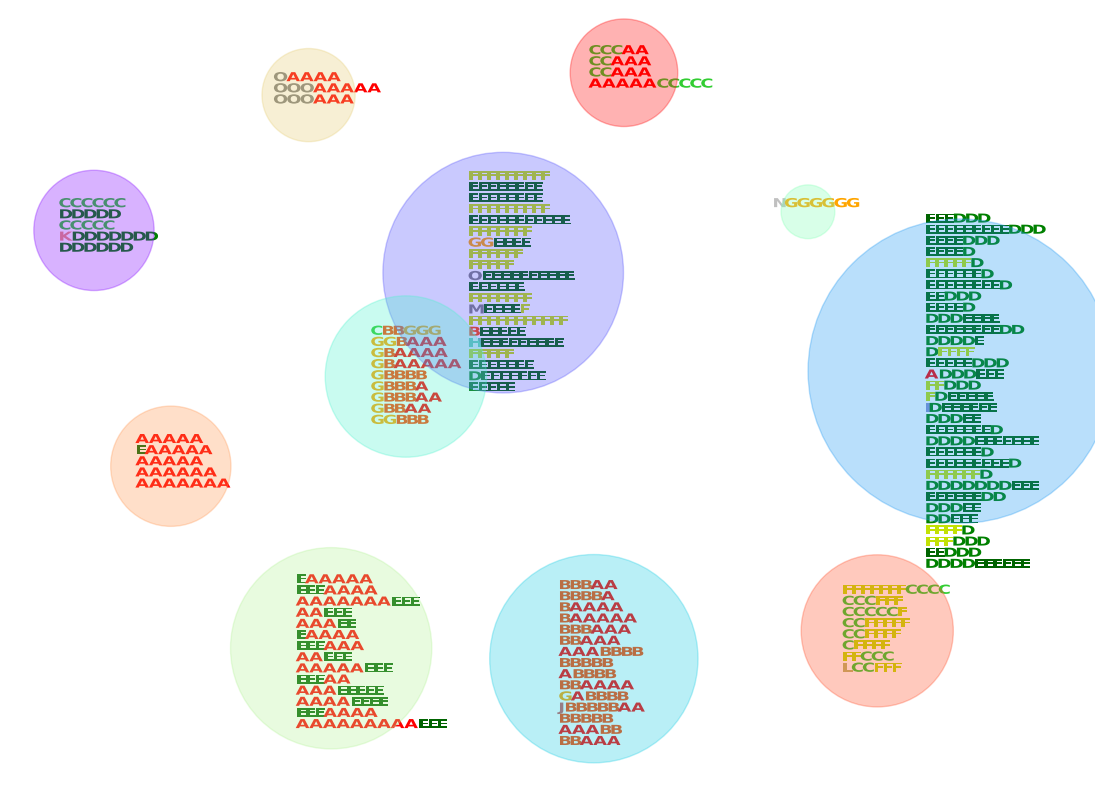

In [87]:
for i in range(8,94)
motif_init2cluster_vis_all(input_path="./init_concat.csv", n_clusters=11, fillna_method="ffill", linkage_method="complete", random_state=7, font_scale=0.004,font_v_scale=9, fig_w=14, fig_h=10, node_size=1500, node_dist=0.05)


DTW computation time: 4.645030736923218 seconds
Clustering Duration: 0:00:00.001256
Number of cluster labels: 116
11


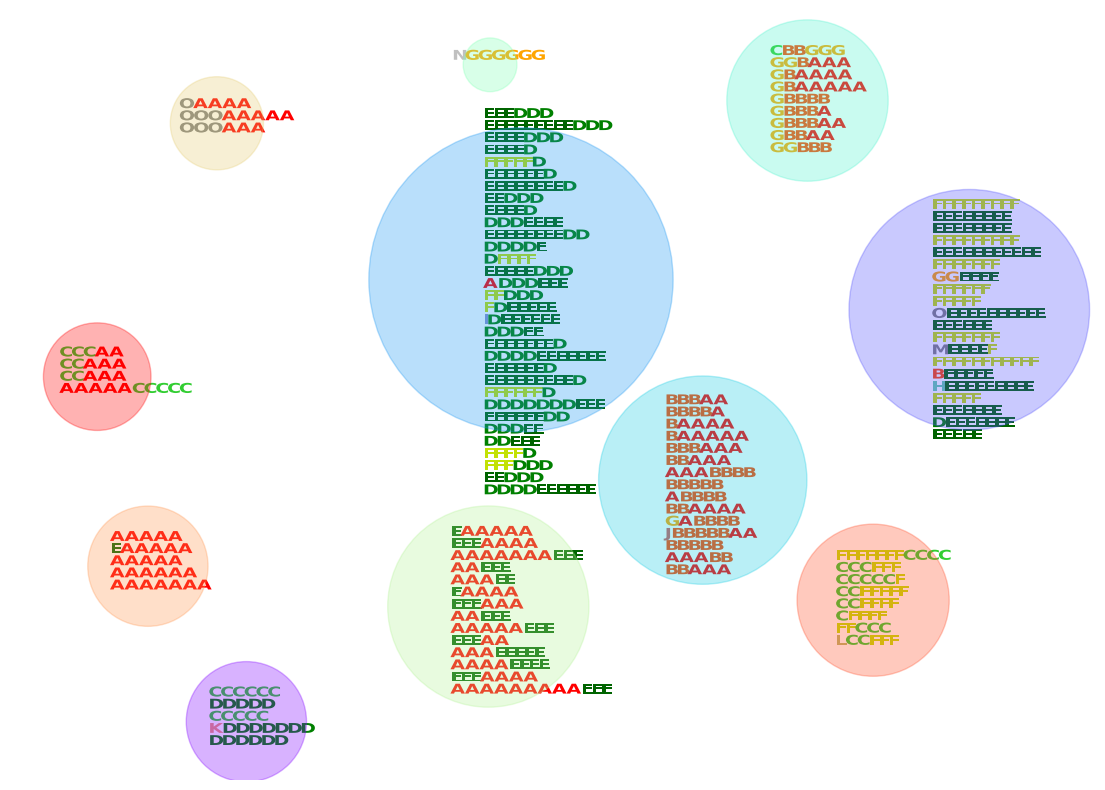

In [72]:
# test
motif_init2cluster_vis_all(input_path="./init_concat.csv", n_clusters=11, fillna_method="ffill", linkage_method="complete", random_state=95, font_scale=0.004,font_v_scale=9, fig_w=14, fig_h=10, node_size=1500, node_dist=0.05)
# test passed

In [65]:
def motif_init2umap(input_path="./init_concat.csv", n_clusters=11, fillna_method="ffill", n_neighbors=5, min_dist=0.3, random_state=2):
    """
    Generate a UMAP embedding of the given data.

    Parameters:

    - input_path: .csv file of all motifs with high attention score
    
    - n_clusters: number of clusters

    - n_neighbors: int (default=5), The size of local neighborhood (in terms of number of neighboring sample points) 
      used for manifold approximation. Larger values result in a more global view of the manifold, while smaller values emphasize local data structures. 
      Adjust according to the desired granularity of the embedding.
      
    - mid_dist: float (default=0.3), The minimum distance between embedded points in the low-dimensional space. 
      Smaller values allow points to cluster more tightly in the embedding, which is useful for identifying finer substructures within the data. 
      Larger values help preserve the overall topology of the data by preventing points from clustering too tightly.
    """
    df_sequences = motif_init2df(input_path=input_path)
    X_train = df_sequences.loc[:, df_sequences.columns != 'position']
    X_train = X_train.astype('float64')  # Convert to float64
    # X_filled = X_train.fillna(X_train.mean())
    if fillna_method==0:
        X_train_filled = X_train.fillna(0)
    if fillna_method=="ffill":
        X_train_filled = X_train.fillna(method=fillna_method) 

    dtw_distance_matrix, y_pred = motif_init2pred_incl_ff_fr(input_path=input_path, n_clusters=n_clusters, fillna_method=fillna_method)

    # Now apply UMAP on the cleaned data
    from umap import UMAP
    # # seed=111
    # # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed)
    # umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    umap_reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_jobs=1)

    # umap_embedding = umap_reducer.fit_transform(X_train_filled.T)  # Ensure the data is transposed if necessary
    umap_embedding = umap_reducer.fit_transform(dtw_distance_matrix)  # Ensure the data is transposed if necessary

    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y_pred, cmap='Spectral', s=100, edgecolors='white', linewidth=0.6)

    # Create a color bar with ticks for each cluster label
    colorbar = plt.colorbar(scatter, ticks=np.arange(0, 11))
    colorbar.set_label('Cluster label')

    # Set the plot title and labels
    plt.title('UMAP Projection After Agglomerative Clustering', fontsize=14)
    plt.xlabel('UMAP Dimension 1', fontsize=14)
    plt.ylabel('UMAP Dimension 2', fontsize=14)

    # Show the plot
    plt.show()

In [66]:
# # test for motif_init2umap
# motif_init2umap()
# # test passed